In [1]:
import cv2
import math
import csv
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
from datetime import datetime
%matplotlib inline

In [ ]:
model = YOLO("/home/iabd/Escritorio/7_Reto2_0ndAAkin_G3/Despliegue/pyspark/yolo11l-seg_batch8/best.pt")


0: 640x640 1 Tomate, 2 Lechugas, 1 Pan, 14.9ms
Speed: 10.4ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


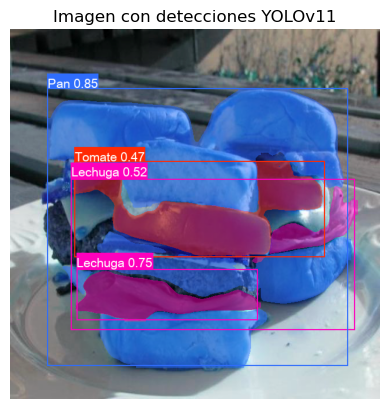


Coordenadas de las cajas detectadas:
Coordenadas de segmentación (contornos):

Clase: Tomate
Confianza: 0.47
Coordenadas (x, y):
[[        157         494]
 [        157         495]
 [        156         496]
 ...
 [        120         453]
 [        125         458]
 [        127         458]]

Clase: Tomate
Confianza: 0.47
Coordenadas (x, y):
[[        165         418]
 [        164         419]
 [        158         419]
 [        157         420]
 [        154         420]
 [        153         421]
 [        151         421]
 [        150         422]
 [        148         422]
 [        147         423]
 [        146         423]
 [        145         424]
 [        143         424]
 [        142         425]
 [        141         425]
 [        139         427]
 [        138         427]
 [        131         434]
 [        131         435]
 [        129         437]
 [        129         438]
 [        128         439]
 [        128         440]
 [        127         441]
 [ 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Cargar la imagen
img = Image.open("/home/iabd/Escritorio/Proyecto_Final_1/dataset_fotos/test/images/00000797_jpg.rf.73a875c685e72fac78d7892e6670a5a6.jpg")

# Realizar predicción
resultados = model(img)  # Asegúrate de que el modelo es YOLOv11-seg

# Mostrar imagen con anotaciones (opcional)
pred = resultados[0].plot()  # Dibuja bboxes + máscaras
plt.imshow(pred)
plt.axis("off")
plt.title("Imagen con detecciones YOLOv11")
plt.show()

# Obtener y mostrar las coordenadas de las cajas
print("\nCoordenadas de las cajas detectadas:")
for i, deteccion in enumerate(resultados[0].boxes):
    # Las coordenadas están en formato (x1, y1, x2, y2)
    coordenadas = deteccion.xyxy[0].tolist()
    confianza = deteccion.conf[0].item()
    clase_id = deteccion.cls[0].item()
    nombre_clase = resultados[0].names[clase_id]

# Extraer las coordenadas de segmentación (polígonos)
segmentaciones = resultados[0].masks.xy  # Lista de arrays con coordenadas (x,y) de los contornos

# Mostrar las coordenadas de segmentación
print("Coordenadas de segmentación (contornos):")
for i, segmentacion in enumerate(segmentaciones):
    print(f"\nClase: {nombre_clase}")
    print(f"Confianza: {confianza:.2f}")
    print(f"Coordenadas (x, y):\n{segmentacion}")  # Array de forma (N, 2) donde N = número de puntos

# Si quieres guardar todos los polígonos en un único array:
#todos_los_poligonos = np.concatenate([seg for seg in segmentaciones], axis=0)
#print("\nTodos los puntos de segmentación concatenados:\n", todos_los_poligonos)

In [ ]:
import os
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from pyspark.sql import SparkSession
from hdfs import InsecureClient
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Configuración
LOCAL_FOLDER = '/app/local_images'
HDFS_FOLDER = '/ondaakin/imagenes'
HDFS_FOLDER_PREP = '/ondaakin/imagenes_preprocesadas'
HDFS_URL = 'http://g3-namenode:50070'
MODEL_PATH = "/app/yolo11l-seg_batch8/best.pt"

# Crear una sesión de Spark
def create_spark_session():
    return SparkSession.builder.appName("UploadImagesToHDFS").getOrCreate()

# Crear cliente HDFS
def create_hdfs_client():
    return InsecureClient(HDFS_URL, user='hadoop')

# Subir archivo a HDFS
def upload_to_hdfs(hdfs_client, file_path, hdfs_target_folder):
    try:
        hdfs_path = os.path.join(hdfs_target_folder, os.path.basename(file_path))
        
        with open(file_path, 'rb') as local_file:
            hdfs_client.write(hdfs_path, local_file, overwrite=True)
            
        print(f"Archivo {file_path} subido a HDFS en {hdfs_path}")
        return True
    except Exception as e:
        print(f"Error al subir {file_path} a HDFS: {e}")
        return False

# Procesar imagen con YOLO y guardar imagen con detecciones
def process_image_with_yolo(image_path, hdfs_client):
    try:
        # Cargar modelo YOLO
        model = YOLO(MODEL_PATH)
        
        # Cargar la imagen
        img = Image.open(image_path)
        
        # Realizar predicción
        resultados = model(img)
        
        # Generar imagen con anotaciones
        pred = resultados[0].plot()  # Esto devuelve un numpy array
        
        # Convertir numpy array a imagen PIL
        pred_img = Image.fromarray(pred[..., ::-1])  # Convertir BGR (OpenCV) a RGB
        
        # Guardar imagen localmente temporalmente
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        output_image_path = f"/tmp/{base_name}_detections.jpg"
        pred_img.save(output_image_path)
        
        # Subir imagen con detecciones a HDFS
        upload_success = upload_to_hdfs(hdfs_client, output_image_path, HDFS_FOLDER_PREP)
        
        # Eliminar archivo temporal
        os.remove(output_image_path)
        
        return upload_success
    except Exception as e:
        print(f"Error al procesar imagen {image_path} con YOLO: {e}")
        return False

# Manejador de eventos
class ImageEventHandler(FileSystemEventHandler):
    def __init__(self, hdfs_client):
        self.hdfs_client = hdfs_client
        self.model = None  # Podrías cargar el modelo aquí si quieres reutilizarlo

    def on_created(self, event):
        if not event.is_directory and event.src_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Nueva imagen detectada: {event.src_path}")
            time.sleep(1)  # Esperar a que el archivo esté completamente escrito
            
            # Subir imagen original a HDFS
            if upload_to_hdfs(self.hdfs_client, event.src_path, HDFS_FOLDER):
                # Procesar imagen y subir resultados
                process_image_with_yolo(event.src_path, self.hdfs_client)

# Monitoreo de carpeta
def monitor_folder():
    spark = create_spark_session()
    hdfs_client = create_hdfs_client()
    
    # Crear carpetas HDFS si no existen
    for folder in [HDFS_FOLDER, HDFS_FOLDER_PREP]:
        if not hdfs_client.status(folder, strict=False):
            hdfs_client.makedirs(folder)
    
    event_handler = ImageEventHandler(hdfs_client)
    observer = Observer()
    observer.schedule(event_handler, path=LOCAL_FOLDER, recursive=False)
    observer.start()
    print(f"Monitoreando la carpeta: {LOCAL_FOLDER}")
    
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

if __name__ == "__main__":
    monitor_folder()